In [1]:
# default_exp models.nbeats.nbeats

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import os
import random
import time
from collections import defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import torch as t
from torch import optim
from pathlib import Path
from functools import partial

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader
from nixtla.models.nbeats.nbeats_model import NBeats, NBeatsBlock, IdentityBasis, TrendBasis, SeasonalityBasis
from nixtla.models.nbeats.nbeats_model import ExogenousBasisInterpretable, ExogenousBasisWavenet, ExogenousBasisTCN
from nixtla.losses.pytorch import MAPELoss, MASELoss, SMAPELoss, MSELoss, MAELoss, PinballLoss
from nixtla.losses.numpy import mae, mse, mape, smape, rmse, pinball_loss

In [4]:
#export
def init_weights(module, initialization):
    if type(module) == t.nn.Linear:
        if initialization == 'orthogonal':
            t.nn.init.orthogonal_(module.weight)
        elif initialization == 'he_uniform':
            t.nn.init.kaiming_uniform_(module.weight)
        elif initialization == 'he_normal':
            t.nn.init.kaiming_normal_(module.weight)
        elif initialization == 'glorot_uniform':
            t.nn.init.xavier_uniform_(module.weight)
        elif initialization == 'glorot_normal':
            t.nn.init.xavier_normal_(module.weight)
        elif initialization == 'lecun_normal':
            pass #t.nn.init.normal_(module.weight, 0.0, std=1/np.sqrt(module.weight.numel()))
        else:
            assert 1<0, f'Initialization {initialization} not found'

class Nbeats(object):
    """
    Future documentation
    """
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    IDENTITY_BLOCK = 'identity'

    def __init__(self,
                 input_size_multiplier,
                 output_size,
                 shared_weights,
                 activation,
                 initialization,
                 stack_types,
                 n_blocks,
                 n_pooling_kernel,
                 n_freq_downsample,
                 n_layers,
                 n_hidden,
                 n_harmonics,
                 n_polynomials,
                 exogenous_n_channels,
                 batch_normalization,
                 dropout_prob_theta,
                 dropout_prob_exogenous,
                 x_s_n_hidden,
                 learning_rate,
                 lr_decay,
                 n_lr_decay_steps,
                 weight_decay,
                 l1_theta,
                 n_iterations,
                 early_stopping,
                 loss,
                 loss_hypar,
                 val_loss,
                 frequency,
                 random_seed,
                 seasonality,
                 device=None):
        super(Nbeats, self).__init__()
        """
        N-BEATS model.

        Parameters
        ----------
        input_size_multiplier: int
            Multiplier to get insample size.
            Insample size = input_size_multiplier * output_size
        output_size: int
            Forecast horizon.
        shared_weights: bool
            If True, repeats first block.
        activation: str
            Activation function.
            An item from ['relu', 'softplus', 'tanh', 'selu', 'lrelu', 'prelu', 'sigmoid'].
        initialization: str
            Initialization function.
            An item from ['orthogonal', 'he_uniform', 'glorot_uniform', 'glorot_normal', 'lecun_normal'].
        stack_types: List[str]
            List of stack types.
            Subset from ['seasonality', 'trend', 'identity', 'exogenous', 'exogenous_tcn', 'exogenous_wavenet'].
        n_blocks: List[int]
            Number of blocks for each stack type.
            Note that len(n_blocks) = len(stack_types).
        n_layers: List[int]
            Number of layers for each stack type.
            Note that len(n_layers) = len(stack_types).
        n_hidden: List[List[int]]
            Structure of hidden layers for each stack type.
            Each internal list should contain the number of units of each hidden layer.
            Note that len(n_hidden) = len(stack_types).
        n_harmonics: List[int]
            Number of harmonic terms for each stack type.
            Note that len(n_harmonics) = len(stack_types).
        n_polynomials: List[int]
            Number of polynomial terms for each stack type.
            Note that len(n_polynomials) = len(stack_types).
        exogenous_n_channels:
            Exogenous channels for non-interpretable exogenous basis.
        batch_normalization: bool
            Whether perform batch normalization. 
        dropout_prob_theta: float
            Float between (0, 1).
            Dropout for Nbeats basis.
        dropout_prob_exogenous: float
            Float between (0, 1).
            Dropout for exogenous basis.
        x_s_n_hidden: int
            Number of encoded static features to calculate.
        learning_rate: float
            Learning rate between (0, 1).
        lr_decay: float
            Decreasing multiplier for the learning rate.
        n_lr_decay_steps: int
            Period for each lerning rate decay.
        weight_decay: float
            L2 penalty for optimizer.
        l1_theta: float
            L1 regularization for the loss function.
        n_iterations: int
            Number of training steps.
        early_stopping: int
            Early stopping interations.
        loss: str
            Loss to optimize.
            An item from ['MAPE', 'MASE', 'SMAPE', 'MSE', 'MAE', 'PINBALL', 'PINBALL2'].
        loss_hypar:
            Hyperparameter for chosen loss.
        val_loss:
            Validation loss.
            An item from ['MAPE', 'MASE', 'SMAPE', 'RMSE', 'MAE', 'PINBALL'].
        frequency: str
            Time series frequency.
        random_seed: int
            random_seed for pseudo random pytorch initializer and
            numpy random generator.
        seasonality: int
            Time series seasonality.
            Usually 7 for daily data, 12 for monthly data and 4 for weekly data.
        device: Optional[str]
            If None checks 'cuda' availability.
            An item from ['cuda', 'cpu'].
        """

        if activation == 'selu': initialization = 'lecun_normal'

        #------------------------ Model Attributes ------------------------#
        # Architecture parameters
        self.input_size = int(input_size_multiplier*output_size)
        self.output_size = output_size
        self.shared_weights = shared_weights
        self.activation = activation
        self.initialization = initialization
        self.stack_types = stack_types
        self.n_blocks = n_blocks
        self.n_pooling_kernel = n_pooling_kernel
        self.n_freq_downsample = n_freq_downsample
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_harmonics = n_harmonics
        self.n_polynomials = n_polynomials
        self.exogenous_n_channels = exogenous_n_channels

        # Regularization and optimization parameters
        self.batch_normalization = batch_normalization
        self.dropout_prob_theta = dropout_prob_theta
        self.dropout_prob_exogenous = dropout_prob_exogenous
        self.x_s_n_hidden = x_s_n_hidden
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.n_lr_decay_steps = n_lr_decay_steps
        self.weight_decay = weight_decay
        self.n_iterations = n_iterations
        self.early_stopping = early_stopping
        self.loss = loss
        self.loss_hypar = loss_hypar
        self.val_loss = val_loss
        self.l1_theta = l1_theta
        self.l1_conv = 1e-3 # Not a hyperparameter
        self.random_seed = random_seed

        # Data parameters
        self.frequency = frequency
        self.seasonality = seasonality
        #self.scaler = scaler

        if device is None:
            device = 'cuda' if t.cuda.is_available() else 'cpu'
        self.device = device

        self._is_instantiated = False

    def create_stack(self):        
        #------------------------ Model Definition ------------------------#
        block_list = []
        self.blocks_regularizer = []
        for i in range(len(self.stack_types)):
            #print(f'| --  Stack {self.stack_types[i]} (#{i})')
            for block_id in range(self.n_blocks[i]):
                
                # Batch norm only on first block
                if (len(block_list)==0) and (self.batch_normalization):
                    batch_normalization_block = True
                else:
                    batch_normalization_block = False
                
                # Dummy of regularizer in block. Override with 1 if exogenous_block
                self.blocks_regularizer += [0]

                # Shared weights
                if self.shared_weights and block_id>0:
                    nbeats_block = block_list[-1]
                else:
                    if self.stack_types[i] == 'seasonality':
                        nbeats_block = NBeatsBlock(n_y = self.n_y,
                                                   input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   n_pooling_kernel=self.n_pooling_kernel[i],
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim= self.n_y * 4 * int(
                                                        np.ceil(self.n_harmonics / 2 * self.output_size) - (self.n_harmonics - 1)),
                                                   basis=SeasonalityBasis(harmonics=self.n_harmonics,
                                                                          backcast_size=self.input_size,
                                                                          forecast_size=self.output_size,
                                                                          n_freq_downsample=self.n_freq_downsample[i]),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'trend':
                        nbeats_block = NBeatsBlock(n_y = self.n_y,
                                                   input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   n_pooling_kernel=self.n_pooling_kernel[i],
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim= self.n_y * 2 * (self.n_polynomials + 1),
                                                   basis=TrendBasis(degree_of_polynomial=self.n_polynomials,
                                                                    backcast_size=self.input_size,
                                                                    forecast_size=self.output_size,
                                                                    n_freq_downsample=self.n_freq_downsample[i]),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'identity':
                        new_theta_n_dim = self.n_y * (self.input_size + self.output_size//self.n_freq_downsample[i])
                        nbeats_block = NBeatsBlock(n_y = self.n_y,
                                                   input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   n_pooling_kernel=self.n_pooling_kernel[i],
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim= new_theta_n_dim,
                                                   basis=IdentityBasis(backcast_size=self.input_size,
                                                                       forecast_size=self.output_size,
                                                                       n_freq_downsample=self.n_freq_downsample[i]),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*self.n_x_t,
                                                   basis=ExogenousBasisInterpretable(),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_tcn':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden = self.x_s_n_hidden,
                                                   theta_n_dim = 2*(self.exogenous_n_channels),
                                                   basis= ExogenousBasisTCN(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                    elif self.stack_types[i] == 'exogenous_wavenet':
                        nbeats_block = NBeatsBlock(input_size=self.input_size,
                                                   output_size=self.output_size,
                                                   x_t_n_inputs=self.n_x_t,
                                                   x_s_n_inputs = self.n_x_s,
                                                   x_s_n_hidden= self.x_s_n_hidden,
                                                   theta_n_dim=2*(self.exogenous_n_channels),
                                                   basis=ExogenousBasisWavenet(self.exogenous_n_channels, self.n_x_t),
                                                   n_layers=self.n_layers[i],
                                                   theta_n_hidden=self.n_hidden[i],
                                                   batch_normalization=batch_normalization_block,
                                                   dropout_prob=self.dropout_prob_theta,
                                                   activation=self.activation)
                        self.blocks_regularizer[-1] = 1
                    else:
                        assert 1<0, f'Block type not found!'
                # Select type of evaluation and apply it to all layers of block
                if self.initialization != 'default':
                    init_function = partial(init_weights, initialization=self.initialization)
                    nbeats_block.layers.apply(init_function)
                #print(f'     | -- {nbeats_block}')
                block_list.append(nbeats_block)
        return block_list

    def __loss_fn(self, loss_name: str):
        def loss(x, loss_hypar, forecast, target, mask):
            if loss_name == 'MAPE':
                return MAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MASE':
                return MASELoss(y=target, y_hat=forecast, y_insample=x, seasonality=loss_hypar, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'SMAPE':
                return SMAPELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MSE':
                return MSELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'MAE':
                return MAELoss(y=target, y_hat=forecast, mask=mask) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            elif loss_name == 'PINBALL':
                return PinballLoss(y=target, y_hat=forecast, mask=mask, tau=loss_hypar) + \
                       self.loss_l1_conv_layers() + self.loss_l1_theta()
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss

    def __val_loss_fn(self, loss_name='MAE'):
        #TODO: mase not implemented
        def loss(forecast, target, weights):
            if loss_name == 'MAPE':
                return mape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'SMAPE':
                return smape(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MSE':
                return mse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'RMSE':
                return rmse(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'MAE':
                return mae(y=target, y_hat=forecast, weights=weights)
            elif loss_name == 'PINBALL':
                return pinball_loss(y=target, y_hat=forecast, weights=weights, tau=0.5)
            else:
                raise Exception(f'Unknown loss function: {loss_name}')
        return loss
    
    def loss_l1_conv_layers(self):
        loss_l1 = 0
        for i, indicator in enumerate(self.blocks_regularizer):
            if indicator:
                loss_l1 += self.l1_conv * t.sum(t.abs(self.model.blocks[i].basis.weight))
        return loss_l1
    
    def loss_l1_theta(self):
        loss_l1 = 0
        for block in self.model.blocks:
            for layer in block.modules():
                if isinstance(layer, t.nn.Linear):
                    loss_l1 += self.l1_theta * layer.weight.abs().sum()
        return loss_l1

    def to_tensor(self, x: np.ndarray) -> t.Tensor:
        tensor = t.as_tensor(x, dtype=t.float32).to(self.device)
        return tensor

    def fit(self, train_ts_loader, val_ts_loader=None, n_iterations=None, verbose=True, eval_freq=1):
        # TODO: Indexes hardcoded, information duplicated in train and val datasets
        assert (self.input_size)==train_ts_loader.input_size, \
            f'model input_size {self.input_size} data input_size {train_ts_loader.input_size}'

        # Random Seeds (model initialization)
        t.manual_seed(self.random_seed)
        np.random.seed(self.random_seed)
        random.seed(self.random_seed) #TODO: interaccion rara con window_sampling de validacion

        # Attributes of ts_dataset
        self.n_y, self.n_x_t, self.n_x_s = train_ts_loader.get_n_variables()

        # Instantiate model
        if not self._is_instantiated:
            block_list = self.create_stack()
            self.model = NBeats(t.nn.ModuleList(block_list)).to(self.device)
            self._is_instantiated = True

        # Overwrite n_iterations and train datasets
        if n_iterations is None:
            n_iterations = self.n_iterations

        lr_decay_steps = n_iterations // self.n_lr_decay_steps
        if lr_decay_steps == 0:
            lr_decay_steps = 1

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_steps, gamma=self.lr_decay)
        training_loss_fn = self.__loss_fn(self.loss)
        validation_loss_fn = self.__val_loss_fn(self.val_loss) #Uses numpy losses

        if verbose:
            print('\n')
            print('='*30+' Start fitting '+'='*30)

        #self.loss_dict = {} # Restart self.loss_dict
        start = time.time()
        self.trajectories = {'iteration':[],'train_loss':[], 'val_loss':[]}
        self.final_insample_loss = None
        self.final_outsample_loss = None
        
        # Training Loop
        early_stopping_counter = 0
        best_val_loss = np.inf
        best_insample_loss = np.inf
        best_state_dict = deepcopy(self.model.state_dict())
        break_flag = False
        iteration = 0
        epoch = 0
        while (iteration < n_iterations) and (not break_flag):
            epoch +=1
            for batch in iter(train_ts_loader):
                iteration += 1
                if (iteration > n_iterations) or (break_flag):
                    continue

                self.model.train()
                # Parse batch
                S     = self.to_tensor([]) # <------------------ CHANGE THIS!!!
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = self.to_tensor(batch['sample_mask'])[:, :, -self.output_size:]
                # available_mask = available_mask.unsqueeze(1)
                # outsample_mask = outsample_mask.unsqueeze(1)

                optimizer.zero_grad()
                outsample_y, forecast = self.model(S=S, Y=Y, X=X,
                                                   insample_mask=available_mask,
                                                   return_decomposition=False)
                # print('forecast.shape', forecast.shape)
                # print('forecast', forecast)
                # assert 1<0

                training_loss = training_loss_fn(x=Y, # TODO: eliminate only useful for MASE 
                                                 loss_hypar=self.loss_hypar, 
                                                 forecast=forecast,
                                                 target=outsample_y, 
                                                 mask=outsample_mask)

                # Protection to exploding gradients
                if not np.isnan(float(training_loss)):
                    training_loss.backward()
                    t.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    optimizer.step()
                else:
                    early_stopping_counter = self.early_stopping

                lr_scheduler.step()
                if (iteration % eval_freq == 0):
                    display_string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                                            time.time()-start,
                                                                                            self.loss,
                                                                                            training_loss.cpu().data.numpy())
                    self.trajectories['iteration'].append(iteration)
                    self.trajectories['train_loss'].append(float(training_loss.cpu().data.numpy()))

                    if val_ts_loader is not None:
                        loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                         validation_loss_fn=validation_loss_fn)
                        display_string += ", Outsample {}: {:.5f}".format(self.val_loss, loss)
                        self.trajectories['val_loss'].append(loss)

                        if self.early_stopping:
                            if loss < best_val_loss:
                                # Save current model if improves outsample loss
                                best_state_dict = deepcopy(self.model.state_dict())
                                best_insample_loss = training_loss.cpu().data.numpy()
                                early_stopping_counter = 0
                                best_val_loss = loss
                            else:
                                early_stopping_counter += 1
                            if early_stopping_counter >= self.early_stopping:
                                break_flag = True
                    
                    print(display_string)

                if break_flag:
                    print('\n')
                    print(19*'-',' Stopped training by early stopping', 19*'-')
                    self.model.load_state_dict(best_state_dict)
                    break

        #End of fitting
        if n_iterations > 0:
            # This is batch loss!
            self.final_insample_loss = float(training_loss.cpu().data.numpy()) if not break_flag else best_insample_loss 
            string = 'Step: {}, Time: {:03.3f}, Insample {}: {:.5f}'.format(iteration,
                                                                            time.time()-start,
                                                                            self.loss,
                                                                            self.final_insample_loss)
            if val_ts_loader is not None:
                self.final_outsample_loss = self.evaluate_performance(ts_loader=val_ts_loader, 
                                                                      validation_loss_fn=validation_loss_fn)
                string += ", Outsample {}: {:.5f}".format(self.val_loss, self.final_outsample_loss)
            print(string)
            print('='*30+'  End fitting  '+'='*30)
            print('\n')

    def predict(self, ts_loader, return_decomposition=False):
        self.model.eval()
        assert not ts_loader.shuffle, 'ts_loader must have shuffle as False.'

        forecasts = []
        block_forecasts = []
        outsample_ys = []
        outsample_masks = []
        with t.no_grad():
            for batch in iter(ts_loader):
                
                # Parse batch
                S     = self.to_tensor([])  # <------------------ CHANGE THIS!!!
                Y     = self.to_tensor(batch['Y'])
                X     = self.to_tensor(batch['X'])
                available_mask  = self.to_tensor(batch['available_mask'])
                outsample_mask = batch['sample_mask'][:, :, -self.output_size:]
                # available_mask = available_mask.unsqueeze(1)
                # outsample_mask = outsample_mask.unsqueeze(1)

                outsample_y, forecast, block_forecast = self.model(S=S, Y=Y, X=X,
                                                                   insample_mask=available_mask,
                                                                   return_decomposition=True)
                outsample_ys.append(outsample_y.cpu().data.numpy())
                forecasts.append(forecast.cpu().data.numpy())
                block_forecasts.append(block_forecast.cpu().data.numpy())
                outsample_masks.append(outsample_mask)

        forecasts = np.vstack(forecasts)
        block_forecasts = np.vstack(block_forecasts)
        outsample_ys = np.vstack(outsample_ys)
        outsample_masks = np.vstack(outsample_masks)

        n_series = ts_loader.ts_dataset.n_series
        _, n_components, _, _ = block_forecast.size() #(n_windows, n_components, n_y, output_size)
        n_fcds = len(outsample_ys) // n_series
        outsample_ys = outsample_ys.reshape(n_series, n_fcds, self.n_y, self.output_size)
        forecasts = forecasts.reshape(n_series, n_fcds, self.n_y, self.output_size)
        outsample_masks = outsample_masks.reshape(n_series, n_fcds, self.n_y, self.output_size)
        block_forecasts = block_forecasts.reshape(n_series, n_fcds, n_components, self.n_y, self.output_size)

        self.model.train()
        if return_decomposition:
            return outsample_ys, forecasts, block_forecasts, outsample_masks
        else:
            return outsample_ys, forecasts, outsample_masks
    
    # def forecast(self, Y_df, X_df, f_cols, return_decomposition):
    #     # TODO: protect available_mask from nans
    #     # Last output_size mask for predictions
    #     mask_df = Y_df.copy()
    #     mask_df = mask_df[['unique_id', 'ds']]
    #     sample_mask = np.ones(len(mask_df))
    #     mask_df['sample_mask'] = np.ones(len(mask_df))
    #     mask_df['available_mask'] = np.ones(len(mask_df))
        
    #     # Model inputs
    #     ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, 
    #                                    mask_df=mask_df, f_cols=f_cols, verbose=False)
        
    #     ts_loader = TimeSeriesLoader(model='nbeats',
    #                                  ts_dataset=ts_dataset,
    #                                  window_sampling_limit=500_000,
    #                                  input_size=self.input_size,
    #                                  output_size=self.output_size,
    #                                  idx_to_sample_freq=self.output_size,
    #                                  batch_size=1024,
    #                                  complete_inputs=False,
    #                                  complete_sample=True,
    #                                  shuffle=False)   

    #     # Model prediction
    #     if return_decomposition:
    #         y_true, y_hat, y_hat_dec, _ = self.predict(ts_loader=ts_loader, 
    #                                                    return_decomposition=True)            
            
    #         # Reshaping model outputs
    #         # n_uids, n_fcds, n_comps, n_ltsp -> n_asins, n_fcds, n_ltsp, n_comps
    #         n_asins, n_fcds, n_comps, n_ltsp = y_hat_dec.shape
    #         y_hat_dec = np.transpose(y_hat_dec, (0, 1, 3, 2))
    #         y_hat_dec = y_hat_dec.reshape(-1, n_comps)
            
    #         Y_hat_dec_df = pd.DataFrame(data=y_hat_dec, 
    #                                     columns=['level']+self.stack_types)
            
    #     else:
    #         y_true, y_hat, _ = self.predict(ts_loader=ts_loader, 
    #                                         return_decomposition=False)
        
    #     # Reshaping model outputs
    #     y_true = y_true.reshape(-1)
    #     y_hat  = y_hat.reshape(-1)
        
    #     Y_hat_df = pd.DataFrame({'unique_id': Y_df.unique_id.values,
    #                              'ds': Y_df.ds.values,
    #                              'y': Y_df.y.values,
    #                              'y_hat': y_hat})
    #     if return_decomposition:
    #         Y_hat_df = pd.concat([Y_hat_df, Y_hat_dec_df], axis=1)
    #     Y_hat_df['residual'] = Y_hat_df['y'] - Y_hat_df['y_hat']            
    #     return Y_hat_df
        
    def evaluate_performance(self, ts_loader, validation_loss_fn):
        self.model.eval()

        target, forecast, outsample_mask = self.predict(ts_loader=ts_loader,
                                                        return_decomposition=False)

        complete_loss = validation_loss_fn(target=target, forecast=forecast, weights=outsample_mask)

        self.model.train()
        return complete_loss

    def save(self, model_dir, model_id, state_dict = None):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        if state_dict is None:
            state_dict = self.model.state_dict()

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        print('Saving model to:\n {}'.format(model_file)+'\n')
        t.save({'model_state_dict': state_dict}, model_file)

    def load(self, model_dir, model_id):

        model_file = os.path.join(model_dir, f"model_{model_id}.model")
        path = Path(model_file)

        assert path.is_file(), 'No model_*.model file found in this path!'

        print('Loading model from:\n {}'.format(model_file)+'\n')

        checkpoint = t.load(model_file, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)

# NBEATS USAGE

In [5]:
from nixtla.experiments.utils import *
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader
from matplotlib import pyplot as plt

### LOAD DATA

In [6]:
data = pd.read_csv('../data/healthcare/data_waveforms_icu.csv')
aux = data[['unique_id','PLETH']].groupby('unique_id').min().reset_index()
aux = aux[aux['PLETH']>0]
filter_patients = aux.unique_id.unique()
data = data[data['unique_id'].isin(filter_patients)].reset_index(drop=True)

horizon = 250
#features = ['ART','PLETH']
features = ['PLETH']
n_patients = data.unique_id.nunique() 
          
Y_df = data[['unique_id','ds']+features]
#Y_df['ART'] = (Y_df['ART'] - Y_df['ART'].mean())/Y_df['ART'].std()
Y_df['PLETH'] = (Y_df['PLETH'] - Y_df['PLETH'].mean())/Y_df['PLETH'].std()

#Y_df = data.copy()
Y_df = Y_df.sort_values(['unique_id','ds']).reset_index(drop=True)
#Y_df = Y_df.rename(columns={feature:'y'})
Y_df['ds'] = np.tile(np.array(range(10000)), n_patients)
Y_train_df = Y_df[Y_df['ds']<10000-horizon].reset_index(drop=True)
Y_train_df['ds'] = pd.to_datetime(Y_train_df['ds'])
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

test_mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=horizon, is_test=True)
test_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=None, S_df=None, mask_df=test_mask_df, verbose=True)

/Users/cchallu/anaconda3/envs/nixtla/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
Y_df.head()

,unique_id,ds,PLETH
0,20190625_1794312_1059078,1970-01-01 00:00:00.000000000,-1.305891
1,20190625_1794312_1059078,1970-01-01 00:00:00.000000001,-1.113707
2,20190625_1794312_1059078,1970-01-01 00:00:00.000000002,-0.874776
3,20190625_1794312_1059078,1970-01-01 00:00:00.000000003,-0.638441
4,20190625_1794312_1059078,1970-01-01 00:00:00.000000004,-0.415093


In [107]:
mc = {'model':'nbeats',
      # Architecture parameters
      'input_size_multiplier': 1,
      'output_size': horizon,
      'shared_weights': False,
      'activation': 'relu',
      'initialization': 'glorot_normal',
      #'stack_types': ['trend', 'seasonality'],
      'stack_types': ['identity', 'identity', 'identity'],
      'n_blocks': [1, 1, 1],
      'n_layers': [2, 2, 2],
      'n_pooling_kernel': [1, 1, 1],
      'n_freq_downsample': [75, 8, 1], # 75, 8, 1]
      'n_hidden': 256,
      'n_polynomials': 2,
      'n_harmonics': 2,
      'exogenous_n_channels': 0,
      'x_s_n_hidden': 0,
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.0,
      'dropout_prob_exogenous': 0.0,
      'learning_rate': 0.001,
      'lr_decay': 0.5,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.001, 
      'n_iterations': 5_000,
      'early_stopping': 8,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss': 'MAE',
      'loss_hypar': 0.5,
      'val_loss': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': None,
      'window_sampling_limit': 100_000,
      'complete_inputs': True,
      'complete_sample': True,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 1,
      'val_idx_to_sample_freq': 1,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'len_sample_chunks': None,
      'random_seed': 10}

In [108]:
train_ts_dataset, validation_ts_dataset, scaler_y = create_datasets(mc=mc, Y_df=Y_train_df, X_df=None, S_df=None, ds_in_test=horizon, shuffle_outsample=False)
train_ts_loader, val_ts_loader = instantiate_loaders(mc=mc, train_ts_dataset=train_ts_dataset, outsample_ts_dataset=validation_ts_dataset)

test_ts_loader = TimeSeriesLoader(ts_dataset=test_ts_dataset,
                                    model=mc['model'],
                                    window_sampling_limit=int(mc['window_sampling_limit']),
                                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                    output_size=int(mc['output_size']),
                                    idx_to_sample_freq=mc['val_idx_to_sample_freq'],
                                    len_sample_chunks=mc['len_sample_chunks'],
                                    batch_size=1,
                                    n_series_per_batch=mc['n_series_per_batch'],
                                    complete_inputs=mc['complete_inputs'],
                                    complete_sample=mc['complete_sample'],
                                    shuffle=False)

In [109]:
mc['n_hidden_list'] = len(mc['stack_types']) * [ mc['n_layers'][0]*[mc['n_hidden']] ]
model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
                output_size=int(mc['output_size']),
                shared_weights=mc['shared_weights'],
                initialization=mc['initialization'],
                activation=mc['activation'],
                stack_types=mc['stack_types'],
                n_blocks=mc['n_blocks'],
                n_layers=mc['n_layers'],
                n_pooling_kernel=mc['n_pooling_kernel'],
                n_freq_downsample=mc['n_freq_downsample'],
                n_hidden=mc['n_hidden_list'],
                n_harmonics=int(mc['n_harmonics']),
                n_polynomials=int(mc['n_polynomials']),
                x_s_n_hidden=int(mc['x_s_n_hidden']),
                exogenous_n_channels=int(mc['exogenous_n_channels']),
                batch_normalization = mc['batch_normalization'],
                dropout_prob_theta=mc['dropout_prob_theta'],
                dropout_prob_exogenous=mc['dropout_prob_exogenous'],
                learning_rate=float(mc['learning_rate']),
                lr_decay=float(mc['lr_decay']),
                n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                weight_decay=mc['weight_decay'],
                l1_theta=mc['l1_theta'],
                n_iterations=int(mc['n_iterations']),
                early_stopping=int(mc['early_stopping']),
                loss=mc['loss'],
                loss_hypar=float(mc['loss_hypar']),
                val_loss=mc['val_loss'],
                frequency=mc['frequency'],
                seasonality=int(mc['seasonality']),
                random_seed=int(mc['random_seed']))

In [110]:
model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, verbose=True, eval_freq=mc['eval_freq'])



============================== Start fitting ==============================
Step: 50, Time: 1.480, Insample MAE: 0.60347, Outsample MAE: 0.72264
Step: 100, Time: 2.871, Insample MAE: 0.99936, Outsample MAE: 0.64861
Step: 150, Time: 4.351, Insample MAE: 0.35701, Outsample MAE: 0.66048
Step: 200, Time: 5.825, Insample MAE: 0.32321, Outsample MAE: 0.63235
Step: 250, Time: 7.225, Insample MAE: 0.61792, Outsample MAE: 0.60585
Step: 300, Time: 8.617, Insample MAE: 0.45498, Outsample MAE: 0.66814
Step: 350, Time: 10.085, Insample MAE: 0.32895, Outsample MAE: 0.58379
Step: 400, Time: 11.603, Insample MAE: 0.43618, Outsample MAE: 0.57579
Step: 450, Time: 13.065, Insample MAE: 0.17217, Outsample MAE: 0.58684
Step: 500, Time: 14.569, Insample MAE: 0.32316, Outsample MAE: 0.58706
Step: 550, Time: 16.080, Insample MAE: 0.46392, Outsample MAE: 0.54678
Step: 600, Time: 17.527, Insample MAE: 0.95401, Outsample MAE: 0.56889
Step: 650, Time: 18.968, Insample MAE: 0.16132, Outsample MAE: 0.58942
Step: 

In [111]:
#y_true_test, y_hat_test, mask_test = model.predict(ts_loader=test_ts_loader, return_decomposition=False)
y_true_test, y_hat_test, block_forecast, mask_test = model.predict(ts_loader=test_ts_loader, return_decomposition=True)
block_forecast.shape

(14, 1, 4, 1, 250)

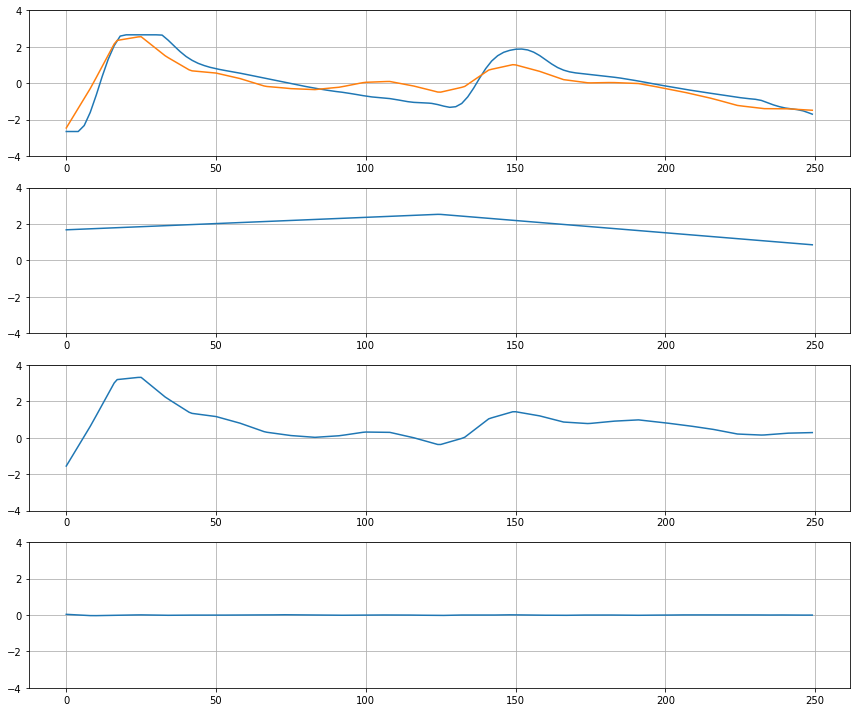

In [118]:
patient = 10
range_plot = 4
fig, ax = plt.subplots(nrows=4, ncols=1, figsize = (12,10))
ax[0].plot(y_true_test[patient, 0, 0, :])
ax[0].plot(y_hat_test[patient, 0, 0, :])
#ax[1].plot(block_forecast[0, 0, 0, 1,:])
ax[1].plot(block_forecast[patient, 0, 1, 0,:])
ax[2].plot(block_forecast[patient, 0, 2, 0,:])
ax[3].plot(block_forecast[patient, 0, 3, 0,:])
#ax[4].plot(block_forecast[patient, 0, 4, 0,:])
ax[0].set_ylim((-range_plot,range_plot))
ax[1].set_ylim((-range_plot,range_plot))
ax[2].set_ylim((-range_plot,range_plot))
ax[3].set_ylim((-range_plot,range_plot))

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
#ax[4].grid()
plt.tight_layout()

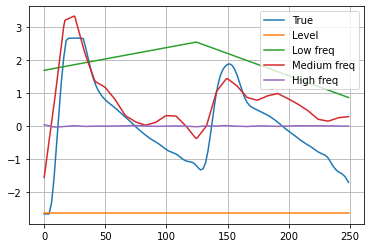

In [116]:
plt.plot(y_true_test[patient, 0, 0, :], label='True')
plt.plot(block_forecast[patient, 0, 0, 0,:], label='Level')
plt.plot(block_forecast[patient, 0, 1, 0,:], label='Low freq')
plt.plot(block_forecast[patient, 0, 2, 0,:], label='Medium freq')
plt.plot(block_forecast[patient, 0, 3, 0,:], label='High freq')
#plt.plot(block_forecast[patient, 0, 4, 0,:], label='High freq')
plt.grid()
plt.legend()

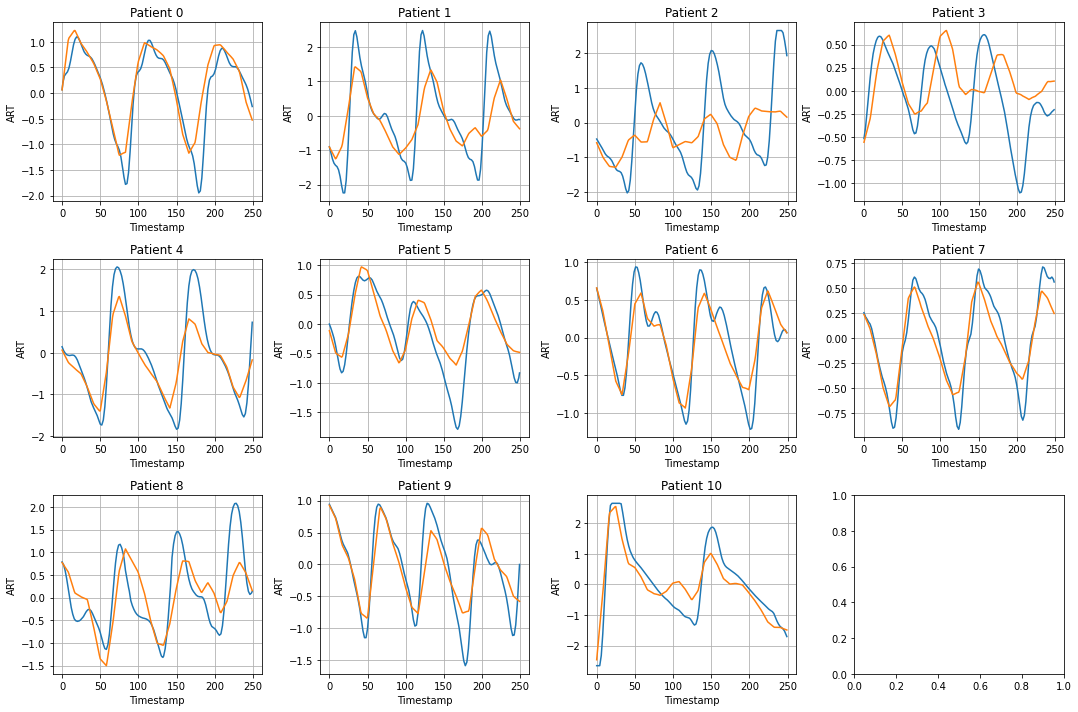

In [117]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (15,10))
for i in range(12):
    ax[i//4, i%4].plot(y_true_test[i, 0, 0, :])
    ax[i//4, i%4].plot(y_hat_test[i, 0, 0, :])
    ax[i//4, i%4].grid(True)
    ax[i//4, i%4].set_xlabel('Timestamp')
    ax[i//4, i%4].set_ylabel('ART')
    ax[i//4, i%4].set_title(f'Patient {i}')
plt.tight_layout()
#plt.savefig(f'./results/{feature}_{horizon}.pdf')
plt.cla()